In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

we want to approximate 
$$(2 \pi) \int_0^{\infty} r f(r) J_0(kr)dr$$
(using ogata 2005 and a change and variable) by:
$$ (2\pi^2) \sum_{j=1} ^\infty (weight/ k) * (\frac{\pi}{hk} \psi( h  \xi _j)) f(\frac{\pi}{kh} \psi( h  \xi _j)) * J_0(\frac{\pi}{h} \psi( h  \xi _j))  d\psi((h \xi _j)) $$
with $$ \psi(t) = t*th(\pi/2 sh(t))$$ and $$ weight = \frac{Y_0(\pi \xi _j)}{J_1 (\pi \xi _j)}$$
and $\xi_j$ aer the zeros of the bessel function of order zero
   

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from pyhank import HankelTransform
import pandas as pd
from scipy import interpolate
from hankel import SymmetricFourierTransform
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr, data
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

class StructureFactor():
    """
    implement various estimators of the structure factor of a point process.
    data : data set of shape nxdim NumPy array (x_data and y_data are the coordinates of data's points)
    n_data :  number of points of in data
    """

    def __init__(self, data):
        if not isinstance(data, np.ndarray):
            raise TypeError("Input data should be an (nxdim) NumPy array")

        try:
            self.n_data = data.shape[0]
            self.d = data.shape[1]
        except:
            raise IndexError("Input data should be an (nxdim) NumPy array")

        if self.d != 2:
            raise ValueError("The library only supports 2D patterns so far")
        self.data = np.array(data)
        self.x_data = data[:, 0]
        self.y_data = data[:, 1]
        #self.n_data = max(self.x_data.shape)

    def get_scattering_intensity_estimate(self, x_waves, y_waves):
        """compute the ensemble estimator described in http://www.scoste.fr/survey_hyperuniformity.pdf.(equation 4.5) 
        which is an approximation of the structure factor, but at zero it gives different result.
        x_waves : x coordinates of the wave vector 
        y_waves : y coordinates of the wave vector
        si_ : the sum inthe formula of the scattering intensity
        si : scattering intensity of data for wave vectors defined by (x_waves, y_waves)
        """
        self.x_waves = x_waves
        self.y_waves = y_waves
        if x_waves.shape != y_waves.shape :
            raise IndexError("x_waves and y_waves should have the same shape.")
        si_ = 0 # initial value of the sum in the scattering intensity
        x_data = self.x_data 
        y_data = self.y_data 
        n_data = self.n_data
        for k in range(0,n_data):
            si_ = si_ + np.exp(- 1j * (x_waves * x_data[k] + y_waves * y_data[k]))
        self.si = (1 / n_data)*np.abs(si_) ** 2
        return self.si

    def plot_scattering_intensity_estimate(self, arg):
        """plot 2D and plot 1D
        wave_lengh : norm of the waves defined by (x_waves, y_waves)
        arg : (str) could be "all", "color_level" or "plot".
             define the type of plot to be visualized
        x_ones_, ones_ : vectors implemented to add the line y=1 to the plot whic correspond to the 
                        theoretical value of the structure factor of a Poisson point process
        """
        x_waves = self.x_waves
        y_waves = self.y_waves
        si = self.si
        wave_lengh =  np.sqrt(np.abs(x_waves)**2 + np.abs(y_waves)**2 )
        ones_ = np.ones((x_waves.shape)).T
        x_ones_ = np.linspace(np.min(wave_lengh), np.max(wave_lengh), np.max(x_waves.shape))
        if arg == "all":
            if np.min(x_waves.shape) == 1 or np.min(y_waves.shape) == 1 :
                raise ValueError("X_waves, Y_waves should be meshgrids or choose arg = 'plot'. ")
            else: 
                fig , ax = plt.subplots(1, 3, figsize=(24, 7))
                ax[0].plot(self.x_data, self.y_data, 'b.')
                ax[0].title.set_text("data")
                ax[1].loglog(wave_lengh, si, 'k,')
                ax[1].loglog(x_ones_, ones_, 'r--')
                ax[1].legend(["Scattering intensity", "y=1" ], shadow=True,loc=1)
                ax[1].set_xlabel("wave lengh (k)")
                ax[1].set_ylabel("scattering intensity (SI(k))")
                ax[1].title.set_text("loglog plot")
                f_0 = ax[2].imshow(np.log10(si), extent=[-np.log10(si).shape[1]/2., np.log10(si).shape[1]/2., -np.log10(si).shape[0]/2., np.log10(si).shape[0]/2. ], cmap="PRGn")
                fig.colorbar(f_0, ax = ax[2])
                ax[2].title.set_text("scattering intensity")
                plt.show()
        elif arg == "plot":
            plt.loglog(wave_lengh, si, 'k,')
            plt.loglog(x_ones_, ones_, 'r--')
            plt.legend(['Scattering intensity','y=1'], loc=1)
            plt.xlabel("wave lengh (k)")
            plt.ylabel("Scattering intensity (SI(k))")
            plt.title("loglog plot")
            plt.show()
        elif arg == "color_level":
            if np.min(x_waves.shape) == 1 or np.min(y_waves.shape) == 1 :
                
                raise ValueError("X_waves, Y_waves should be meshgrids or choose arg = 'plot'. ")
            else :
                f_0 = plt.imshow(np.log10(si), extent=[-np.log10(si).shape[1]/2., np.log10(si).shape[1]/2., -np.log10(si).shape[0]/2., np.log10(si).shape[0]/2. ], cmap="PRGn")
                plt.colorbar(f_0)
                plt.title("Scattering intensity")
                plt.show()
        else :
            raise ValueError("arg should be one of the following str: 'all', 'plot' and 'color_level'.  ")
    def get_pcf_estimate(self, raduis, args, correction_=None, r_vec=None, r_max=None):
        """compute the pair correlation function of data using the R packadge spatstat pcf.ppp, and pcf. fv
        args : (srt) should be 'fv' or 'ppp'. If it is set to be 'fv' then pcf.fv is used, if 'ppp' then 
              pcf.ppp is used. 
        raduis: raduis of the ball which contains the data on which the pair correlation function will
                be conmputed.
        correction_: if args= 'ppp' : correction ( should be one of : "translate", "Ripley", "isotropic",
                    "best", "good" , "all"
                    if args='fv' : keep the default value 'None'.
        r_vec : if args = 'ppp' : keep the default 'None'
                if arg = 'fv' : is the vector of raduis to evaluate g. it's prefered to can keep the default 
                or to set an r_max 
        r_max : if args = 'ppp' : keep the default 'None'
                if arg = 'fv' : r_max is the maximum raduis on which g will be evaluated
        g: the pair correlation function 
        g_pd: the pair coorelation function as data frame
        x_data_r: x_data transfered into R object 
        y_data_r: y_data transfered into R object
        data_r : data transformed into R object
        
        for more details see : "https://rdrr.io/cran/spatstat/man/pcf.ppp.html")
              if arg_1 = "fv": arg_2 is the method ("a", "b", "c" or "d")
        """
        if args not in ["fv", "ppp"]:
            raise ValueError(" args should be 'fv', or 'ppp'")
        if not np.isscalar(raduis):
            raise ValueError("raduis must be a scalar")
        
        utils = rpackages.importr('utils')
        utils.chooseCRANmirror(ind = 1)
        spatstat = rpackages.importr('spatstat')
        disc = robjects.r("disc")
        center = robjects.r('c')
        r_base = importr('base')
        ppp = robjects.r('ppp')
        pcf = robjects.r('pcf')
        #pcf_fv = robjects.r('pcf.fv')
        Kest = robjects.r('Kest')
        #r_hist = robjects.r("hist")
        #barplot = robjects.r("barplot")
        #owin = robjects.r("owin") #si on prend un rectangle

        x_data = self.x_data 
        y_data = self.y_data 


        x_data_r = robjects.vectors.FloatVector(x_data)
        y_data_r = robjects.vectors.FloatVector(y_data)
        
        data_r = ppp(x_data_r, y_data_r, window=disc(raduis, center(0, 0)))                    
        if args == "ppp":          
            if correction_ not in ["translate", "Ripley", "isotropic", "best", "good" , "all", None] :
                raise ValueError("correction should be one of the following str: 'translate', 'Ripley', 'isotropic', 'best', 'good' , 'all', 'none'.")
            pcf_estimation = pcf(data_r, correction=correction_)
                             
        if args == "fv":
            if correction_ not in ["a", "b", "c", "d", None] :
                raise ValueError("correction_ should be one of the following str: 'a', 'b', 'c', 'd', None.")  
            robjects.globalenv['data_r'] = data_r #Transfert ppp_data comme variable dans R.
            if r_max != None :
                robjects.globalenv['r_max']= r_max
                robjects.r('kest_data = Kest(data_r, rmax=r_max)')
            elif r_vec is not None:
                robjects.globalenv['r_vec']= r_vec
                r_vec_r = robjects.vectors.FloatVector(r_vec)
                robjects.r('kest_data = Kest(data_r, r=r_vec)')
            else :
                robjects.r('kest_data = Kest(data_r)')
            robjects.globalenv['method_']= correction_
            pcf_estimation = robjects.conversion.rpy2py(robjects.r('pcf.fv(kest_data,  method=method_)'))  
                             
        self.pcf_estimation_pd = pd.DataFrame.from_records(pcf_estimation).fillna(0) # as pandas data frame
        return self.pcf_estimation_pd
    
    def plot_pcf_estimate(self, args):
        """
        plot the pair correlation function estimation using get_pcf_estimate. 
        args: (str), should be 'pcf', 'trans', 'iso' or 'un'
        """
        pcf_estimation_pd = self.pcf_estimation_pd
        g_key = (pcf_estimation_pd.keys()).tolist()
        if g_key.count(args) == 0:
            raise ValueError("The data frame does not contains the chosen args. Check pcf_estimation_pd.keys() to plot one of them. ")
        r_vec = np.array(pcf_estimation_pd["r"])
        g_to_plot = np.array(pcf_estimation_pd[args])
        g_theo = np.array(pcf_estimation_pd["theo"])
        plt.plot(r_vec, g_theo, 'r--', label="y=1")
        plt.scatter(r_vec, g_to_plot, c='k', s=1, label="pcf")
        plt.plot(r_vec, g_to_plot, 'b')
        plt.legend()
        plt.xlabel("r")
        plt.ylabel("g(r)")
        plt.title("Pair correlation function ")
        
    def get_fourier_estimate(self, args, arg_2, intensity, wave_lengh=None): 
        """
         compute the approximation of the structure factor of data by evaluating the fourier transform of the paire
        approximated by the R packadge spatstat
        args: (str) one of the following str: 'pcf', 'ppp_trans', 'ppp_iso' or 'ppp_un'. It specified the method chosen
        to approximate the pcf 
        intensity: intensity of the point process
        'pcf' if pcf.fv is used
        'trans', 'iso' or 'un': if pcf.ppp is used and trans, iso, un to specifiy which edge correction is used
        arg_2: estimation_1, estimation_2
        """
        
        pcf_estimation_pd = self.pcf_estimation_pd
        g_key = (pcf_estimation_pd.keys()).tolist()
        if not np.isscalar(intensity):
            raise ValueError("intensity must be a scalar")
        if g_key.count(args) == 0:
                raise ValueError("The data frame does not contain the chosen args. Check pcf_estimation_pd.keys() to plot one of them. ")
        g_to_plot = np.array(pcf_estimation_pd[args])
        r_vec = np.array(pcf_estimation_pd["r"])
        g_theo = np.array(pcf_estimation_pd["theo"])
        h_estimation = pcf_estimation_pd[args] -1
        if arg_2 == "estimation_2":
            h_estimation_interpolate = interpolate.interp1d(r_vec, h_estimation, axis=0, fill_value='extrapolate', kind='cubic')
            transformer_2 = SymmetricFourierTransform(ndim=2, N=10000, h=0.00001)
            sf_estimation_2 = 1 + intensity * transformer_2.transform(h_estimation_interpolate, wave_lengh, ret_err=False)
            ones_ = np.ones(sf_estimation_2.shape).T
            fig , ax = plt.subplots(1, 2, figsize=(24, 7))
            ax[0].plot(r_vec, g_theo, 'r--', label="y=1")
            ax[0].scatter(r_vec, g_to_plot, c='k', s=1, label="pcf")
            ax[0].plot(r_vec, g_to_plot, 'b')
            ax[0].legend()
            ax[0].set_xlabel("r")
            ax[0].set_ylabel("g(r)")
            ax[0].title.set_text("Pair correlation function ")
            ax[1].plot(wave_lengh[1:], sf_estimation_2[1:],'b' )
            ax[1].scatter(wave_lengh, sf_estimation_2, c='k', s=1, label="sf")  
            ax[1].plot(wave_lengh, ones_, 'r--', label="y=1")
            ax[1].legend()
            ax[1].set_xlabel('k')
            ax[1].set_ylabel('S(k)')
            ax[1].title.set_text('structur factor of data' )
            plt.show()
            return( wave_lengh, sf_estimation_2)
        if arg_2 == "estimation_1":
            h_estimation[0] = -1 
            transformer = HankelTransform(order=0, max_radius=max(pcf_estimation_pd['r']), n_points=pcf_estimation_pd['r'].shape[0])
            sf_estimation = 1 + intensity*transformer.qdht(h_estimation)
            wave_lengh = transformer.kr
            ones_ = np.ones(sf_estimation.shape).T
            fig , ax = plt.subplots(1, 2, figsize=(24, 7))
            ax[0].plot(r_vec, g_theo, 'r--', label="y=1")
            ax[0].scatter(r_vec, g_to_plot, c='k', s=1, label="pcf")
            ax[0].plot(r_vec, g_to_plot, 'b')
            ax[0].legend()
            ax[0].set_xlabel("r")
            ax[0].set_ylabel("g(r)")
            ax[0].title.set_text("Pair correlation function ")
            ax[1].plot(wave_lengh[1:], sf_estimation[1:],'b' )
            ax[1].scatter(wave_lengh, sf_estimation, c='k', s=1, label="sf")  
            ax[1].plot(wave_lengh, ones_, 'r--', label="y=1")
            ax[1].legend()
            ax[1].set_xlabel('k')
            ax[1].set_ylabel('S(k)')
            ax[1].title.set_text('structur factor of data' )
            plt.show()
            return (wave_lengh, sf_estimation)

/opt/anaconda3/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



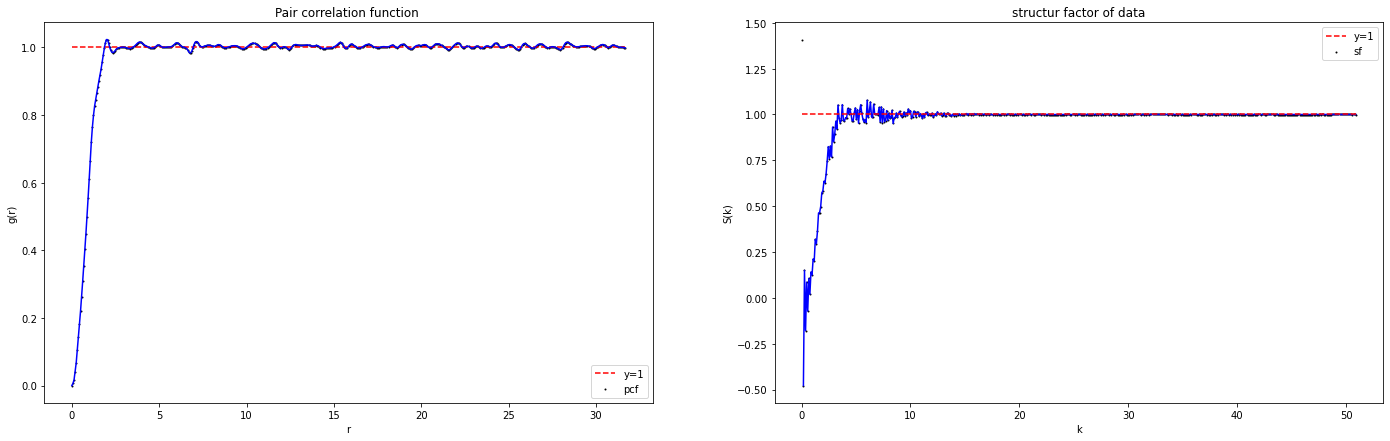

In [3]:
import pickle
with open('big_data_wit_tmaxe15.dat', 'rb') as pickle_file:
    r_pois, n_pois_1, pois_1, push_1, equi_1, r_vec_1, v_pois_1, v_push_1, v_equi_1, t_max, t_max_e = pickle.load(pickle_file, encoding="bytes")
with open('big_gin_1.dat', 'rb') as pickle_file_2:
    n_gin, gin = pickle.load(pickle_file_2, encoding="bytes")
    
my_data_pois = np.array([np.array(np.real(pois_1)).reshape(-1,), np.array(np.imag(pois_1)).reshape(-1,)]).T
my_data_equi = np.array([np.array(np.real(equi_1)).reshape(-1,), np.array(np.imag(equi_1)).reshape(-1,)]).T
my_data_push = np.array([np.array(np.real(push_1)).reshape(-1,), np.array(np.imag(push_1)).reshape(-1,)]).T
my_data_gin = np.array([np.array(np.real(gin)).reshape(-1,), np.array(np.imag(gin)).reshape(-1,)]).T

#data_equi = StructureFactor(my_data_equi)
#data_pois = StructureFactor(my_data_pois)
#data_push = StructureFactor(my_data_push)
data_gin = StructureFactor(my_data_gin)


approx_pcf_gin = data_gin.get_pcf_estimate(100, 'fv', 'b')
k_gin, approx_sf_gin = data_gin.get_fourier_estimate('pcf','estimation_1', 1/np.pi)

In [4]:
import numpy as np
from scipy.integrate import quad
from mpmath import fp as mpm
from scipy.special import gamma, j0, j1, jn, jv, yv
from scipy.special import jn_zeros as _jn_zeros
    
class Symmetric_Fourier_Transform_():

    def __init__(self, ndim=2, N=None, h=0.05):
        self._h = h
        self.ndim = ndim
    
        def roots(N):
            return np.array([mpm.besseljzero(0, i + 1) for i in range(N)]) / np.pi #first N Roots of the Bessel J(nu) functions divided by pi.
        self._zeros = roots(N)
       
        def psi(t):
            return t * np.tanh(np.pi * np.sinh(t) / 2)

        def get_x(h, zeros):
            return np.pi * psi(h * zeros) / h 
        self.x = get_x(h, self._zeros) #pi*psi(h*ksi/pi)
    
        def kernel(x, nu):
            if np.isclose(nu, 0):
                return j0(x)
            if np.isclose(nu, 1):
                return j1(x)
            if np.isclose(nu, np.floor(nu)):
                return jn(int(nu), x)
            return jv(nu, x)
        self.kernel = kernel(self.x, 0) #J_0(pi*psi(h*ksi))

        def weight(zeros):
            return yv(0, np.pi * zeros) / kernel(np.pi * zeros, 1)
        self.w = weight(self._zeros) #(Y_0(pi*zeros)/J_1(pi*zeros))
        
        def d_psi(t):
            t = np.array(t, dtype=float)
            a = np.ones_like(t)
            mask = t < 6
            t = t[mask]
            a[mask] = (np.pi * t * np.cosh(t) + np.sinh(np.pi * np.sinh(t))) / (
                1.0 + np.cosh(np.pi * np.sinh(t))
            )
            return a
        self.dpsi = d_psi(h * self._zeros) #dpsi(h*ksi)        
        self._factor = None

    def _k(self, k):
        return np.array( np.array(k))

    @property
    def _series_fac(self):
        if self._factor is None:
            self._factor = np.pi * self.w * self.kernel * self.dpsi #pi*w*J_0(pi*psi(h*ksi))*dpsi(h*ksi)
        return self._factor

    def _get_series(self, f, k=1):
        with np.errstate(divide="ignore"):  # numpy safely divides by 0
            args = np.divide.outer(self.x, k).T  # x = r*k
        return self._series_fac * f(args) * (self.x)    

    def transform(self, f, k=1):
        k = self._k(k) # k as array
        #k_0 = np.isclose(k, 0) #index for zeros k
        #kn0 = np.invert(k_0) # index  for non zero k
        #k_tmp = k[kn0] # kwithout values close to zero
        k_tmp = k
        knorm = np.array(k_tmp **2) #k**2
        # The basic transform has a norm of 1.
        norm = (2 * np.pi) 
        summation = self._get_series(f, k_tmp) # pi*w*J0(x)
        ret = np.empty(k.shape, dtype=summation.dtype)
        #ret[kn0] = np.array(norm * np.sum(summation, axis=-1) / knorm) #2pi*summation/k**2
        ret = np.array(norm * np.sum(summation, axis=-1) / knorm) #2pi*summation/k**2
        # care about k=0
        #ret_0 = 0
        #if np.any(k_0):

            #def integrand(r):
                #return f(r).real * (r)

            #int_res = quad(integrand, 0, np.inf)
            #ret_0 = int_res[0] * norm
            #ret[k_0] = ret_0
        return ret


In [5]:
pcf_ginibre = lambda x : 1 - np.exp(-x**2)
h_ginibre = lambda x : - np.exp(-x**2)
true_sf_ginibre = lambda x : 1 - np.exp(-x**2/4)
x_2_ = lambda x: x**2
x_2 = lambda x: 0.24*x**2
x_2_2 = lambda x: 0.23*x**2
x_2_3 = lambda x: 0.25*x**2
x_2_1 = lambda x: 0.22*x**2
x_2_4 = lambda x: 0.21*x**2

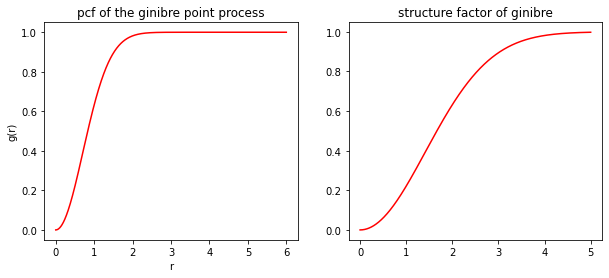

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from scipy.interpolate import interp1d
from hankel import SymmetricFourierTransform
import matplotlib.pyplot as plt
r = np.linspace(0, 6, 1000 )
wave_ = np.linspace(0, 1, 100000)
wave_lengh = np.linspace(0, 5, 10000)
#wave_lengh = np.logspace(-12, 1, 1000)/2
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(r, pcf_ginibre(r), 'r')
ax[0].title.set_text('pcf of the ginibre point process')
ax[0].set_xlabel('r')
ax[0].set_ylabel('g(r)')
ax[1].plot(wave_lengh, true_sf_ginibre(wave_lengh), 'r')
ax[1].title.set_text('structure factor of ginibre')
plt.show()

# using Pyhank

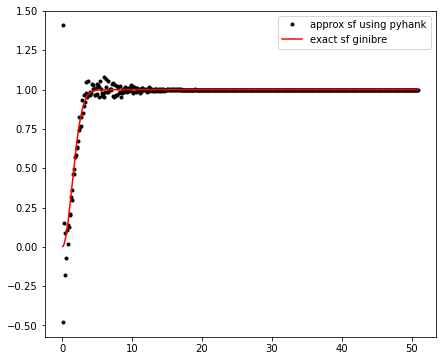

In [7]:
plt.figure(figsize=(7,6))
plt.plot(k_gin, approx_sf_gin, 'k.', label = "approx sf using pyhank")
plt.plot(k_gin, true_sf_ginibre(k_gin), 'r', label= "exact sf ginibre")
plt.legend()
plt.show()

# using Hankle lib and my lib of ogata paper 2005

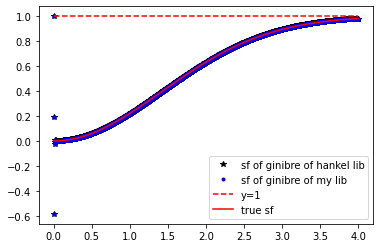

In [11]:
# make sure that the lib work well for the exact pcf
wave_lengh = np.linspace(10e-6, 4, 1000)
N_ = 100
h_ = 0.001
ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)
sf_ginibre = 1 + 1/np.pi*(ft.transform(h_ginibre, wave_lengh, ret_err=False))
sf_ginibre_2 = 1 + 1/np.pi*(ft_2.transform(h_ginibre, wave_lengh))
plt.plot(wave_lengh, sf_ginibre, 'k*', label="sf of ginibre of hankel lib")
plt.plot(wave_lengh, sf_ginibre_2, 'b.', label="sf of ginibre of my lib")
plt.plot(wave_lengh, np.ones((wave_lengh.shape)), 'r--', label="y=1")
plt.plot(wave_lengh, true_sf_ginibre(wave_lengh), 'r', label="true sf")
plt.legend()
plt.show()


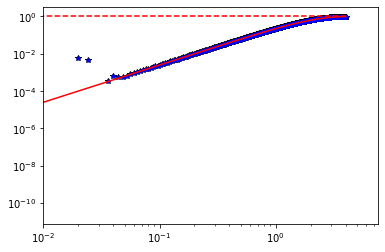

In [12]:
plt.loglog(wave_lengh, sf_ginibre, 'k*', label="sf of ginibre of hankel lib")
plt.loglog(wave_lengh, sf_ginibre_2, 'b.', label="sf of ginibre of my lib")
plt.loglog(wave_lengh, np.ones((wave_lengh.shape)), 'r--', label="y=1")
plt.loglog(wave_lengh, true_sf_ginibre(wave_lengh), 'r', label="true sf")
plt.xlim(10e-3)

plt.show()

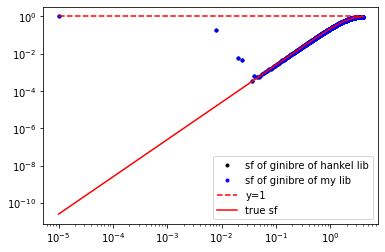

In [13]:
plt.loglog(wave_lengh, sf_ginibre, 'k.', label="sf of ginibre of hankel lib")
plt.loglog(wave_lengh, sf_ginibre_2, 'b.', label="sf of ginibre of my lib")
plt.loglog(wave_lengh, np.ones((wave_lengh.shape)), 'r--', label="y=1")
plt.loglog(wave_lengh, true_sf_ginibre(wave_lengh), 'r', label="true sf")
plt.legend()
plt.show()

my lib and hankel work well for the exact pcf 

# approximation

In [14]:
# interpolation 
from scipy import interpolate
r_pcf = approx_pcf_gin["r"]
approx_h_gin = approx_pcf_gin["pcf"] -1
approx_h_gin_interpolate = interpolate.interp1d(r_pcf, approx_h_gin, axis=0, fill_value='extrapolate', kind='cubic')
h_gin = lambda x : - np.exp(-x**2)
true_sf_ginibre = lambda x : 1 - np.exp(-x**2/4)
approx_gin_sf_2 = 1 + 1/np.pi*ft_2.transform(approx_h_gin_interpolate, wave_lengh)
approx_gin_sf_1 = 1 + 1/np.pi*ft.transform(approx_h_gin_interpolate, wave_lengh, ret_err=False)

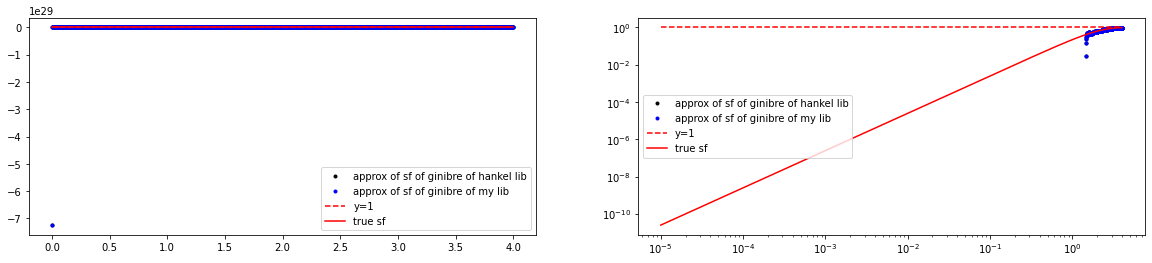

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,4))
ax[0].plot(wave_lengh, approx_gin_sf_1, 'k.', label="approx of sf of ginibre of hankel lib")
ax[0].plot(wave_lengh, approx_gin_sf_2, 'b.', label="approx of sf of ginibre of my lib")
ax[0].plot(wave_lengh, np.ones((wave_lengh.shape)), 'r--', label="y=1")
ax[0].plot(wave_lengh, true_sf_ginibre(wave_lengh), 'r', label="true sf")
ax[0].legend()
ax[1].loglog(wave_lengh, approx_gin_sf_1, 'k.', label="approx of sf of ginibre of hankel lib")
ax[1].loglog(wave_lengh, approx_gin_sf_2, 'b.', label="approx of sf of ginibre of my lib")
ax[1].loglog(wave_lengh, np.ones((wave_lengh.shape)), 'r--', label="y=1")
ax[1].loglog(wave_lengh, true_sf_ginibre(wave_lengh), 'r', label="true sf")
ax[1].legend()
plt.show()



In [16]:
approx_gin_sf_1

array([-7.24446251e+29, -6.89865512e+16, -2.15255494e+15, -2.81854802e+14,
       -6.64353451e+13, -2.16136048e+13, -8.62183927e+12, -3.95899037e+12,
       -2.01512510e+12, -1.10965055e+12, -6.50161954e+11, -4.00553828e+11,
       -2.57219279e+11, -1.71026314e+11, -1.17137319e+11, -8.23041386e+10,
       -5.91300166e+10, -4.33192765e+10, -3.22901073e+10, -2.44432435e+10,
       -1.87611957e+10, -1.45809782e+10, -1.14612368e+10, -9.10241563e+09,
       -7.29759652e+09, -5.90154237e+09, -4.81080415e+09, -3.95069753e+09,
       -3.26663019e+09, -2.71823501e+09, -2.27534315e+09, -1.91518265e+09,
       -1.62040491e+09, -1.37767816e+09, -1.17667398e+09, -1.00932953e+09,
       -8.69305304e+08, -7.51583066e+08, -6.52165027e+08, -5.67847099e+08,
       -4.96046617e+08, -4.34670512e+08, -3.82013758e+08, -3.36680619e+08,
       -2.97523220e+08, -2.63593328e+08, -2.34104306e+08, -2.08400932e+08,
       -1.85935332e+08, -1.66247684e+08, -1.48950708e+08, -1.33717101e+08,
       -1.20269349e+08, -

In [17]:
approx_gin_sf_2

array([-7.24446251e+29, -6.89865512e+16, -2.15255494e+15, -2.81854802e+14,
       -6.64353451e+13, -2.16136048e+13, -8.62183927e+12, -3.95899037e+12,
       -2.01512510e+12, -1.10965055e+12, -6.50161954e+11, -4.00553828e+11,
       -2.57219279e+11, -1.71026314e+11, -1.17137319e+11, -8.23041386e+10,
       -5.91300166e+10, -4.33192765e+10, -3.22901073e+10, -2.44432435e+10,
       -1.87611957e+10, -1.45809782e+10, -1.14612368e+10, -9.10241563e+09,
       -7.29759652e+09, -5.90154237e+09, -4.81080415e+09, -3.95069753e+09,
       -3.26663019e+09, -2.71823501e+09, -2.27534315e+09, -1.91518265e+09,
       -1.62040491e+09, -1.37767816e+09, -1.17667398e+09, -1.00932953e+09,
       -8.69305304e+08, -7.51583066e+08, -6.52165027e+08, -5.67847099e+08,
       -4.96046617e+08, -4.34670512e+08, -3.82013758e+08, -3.36680619e+08,
       -2.97523220e+08, -2.63593328e+08, -2.34104306e+08, -2.08400932e+08,
       -1.85935332e+08, -1.66247684e+08, -1.48950708e+08, -1.33717101e+08,
       -1.20269349e+08, -

# apparement sans approximation on est bien à 10e5 pour le pb avec approximation
j'ai essayer de voir si le problème est dans linterpolation en regardant les valeur de la fonction d'interpolation ou ils sont evalué dans la libraries 
donc j'ai trouvé les zeros de besssel jusqu'à ordre N et evaluer h_ginibre et l'interpolation de l'approximation apprement ila déja ici un probleme car pour l'interpolation elle diverge en fin car il y a trop de zeros en dehors de r_pcf

In [19]:
def _psi(t):
    #t is an array
    return t * np.tanh(np.pi * np.sinh(t) / 2)

def _d_psi(t):
    t = np.array(t, dtype=float)
    a = np.ones_like(t)
    mask = t < 6
    t = t[mask]
    a[mask] = (np.pi * t * np.cosh(t) + np.sinh(np.pi * np.sinh(t))) / (
        1.0 + np.cosh(np.pi * np.sinh(t))
    )
    return a

def _get_x(h, zeros_bessel0):
    return np.pi * _psi(h * zeros_bessel0) / h
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(N_)]) / np.pi
x_ = _get_x(h_, zeros_)
args = np.divide.outer(x_, wave_lengh).T

In [20]:
np.max(args)

4878329.006506744

In [21]:
def _get_x(h, zeros_bessel0):
    return np.pi * _psi(h * zeros_bessel0) / h
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(N_)]) / np.pi
wave_lengh = np.linspace(10e-3, 4, 10000)
N_ = 10000
h_ = 0.001
ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)
x_ = _get_x(h_, zeros_)
x_

array([2.89159187e-03, 1.52356003e-02, 3.74433171e-02, 6.95194999e-02,
       1.11464501e-01, 1.63278133e-01, 2.24960039e-01, 2.96509751e-01,
       3.77926715e-01, 4.69210297e-01, 5.70359781e-01, 6.81374371e-01,
       8.02253197e-01, 9.32995306e-01, 1.07359967e+00, 1.22406519e+00,
       1.38439067e+00, 1.55457486e+00, 1.73461642e+00, 1.92451393e+00,
       2.12426590e+00, 2.33387075e+00, 2.55332685e+00, 2.78263246e+00,
       3.02178578e+00, 3.27078493e+00, 3.52962796e+00, 3.79831282e+00,
       4.07683742e+00, 4.36519955e+00, 4.66339696e+00, 4.97142730e+00,
       5.28928815e+00, 5.61697701e+00, 5.95449131e+00, 6.30182841e+00,
       6.65898556e+00, 7.02595998e+00, 7.40274877e+00, 7.78934899e+00,
       8.18575759e+00, 8.59197147e+00, 9.00798744e+00, 9.43380223e+00,
       9.86941251e+00, 1.03148149e+01, 1.07700058e+01, 1.12349817e+01,
       1.17097390e+01, 1.21942740e+01, 1.26885828e+01, 1.31926616e+01,
       1.37065064e+01, 1.42301132e+01, 1.47634779e+01, 1.53065963e+01,
      

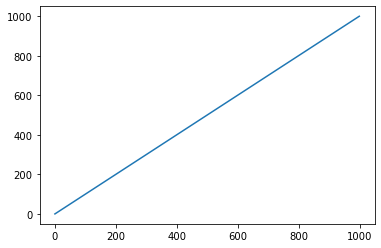

In [22]:
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(1000)]) / np.pi
plt.plot(zeros_)

In [23]:
approx_h_gin_interpolate(args[1,:100])

array([-6.14532535e-01,  1.42512452e-02,  5.26688430e-03,  1.06867750e-03,
       -1.81257177e-03,  3.74340856e+01,  7.54877718e+02,  3.93272337e+03,
        1.27874012e+04,  3.24778705e+04,  7.06854879e+04,  1.38263954e+05,
        2.49959264e+05,  4.25199593e+05,  6.88955008e+05,  1.07266694e+06,
        1.61524729e+06,  2.36414707e+06,  3.37649446e+06,  4.72030216e+06,
        6.47574387e+06,  8.73649986e+06,  1.16111713e+07,  1.52247634e+07,
        1.97202371e+07,  2.52601289e+07,  3.20282393e+07,  4.02313891e+07,
        5.01012433e+07,  6.18962026e+07,  7.59033629e+07,  9.24405414e+07,
        1.11858370e+08,  1.34542455e+08,  1.60915603e+08,  1.91440116e+08,
        2.26620149e+08,  2.67004130e+08,  3.13187260e+08,  3.65814058e+08,
        4.25580988e+08,  4.93239139e+08,  5.69596978e+08,  6.55523162e+08,
        7.51949413e+08,  8.59873460e+08,  9.80362043e+08,  1.11455398e+09,
        1.26366328e+09,  1.42898238e+09,  1.61188532e+09,  1.81383114e+09,
        2.03636720e+09,  

In [24]:
h_ginibre(args[1,:100])

array([-5.95148652e-001, -5.53646421e-007, -1.62096092e-038,
       -5.37128033e-131, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000,

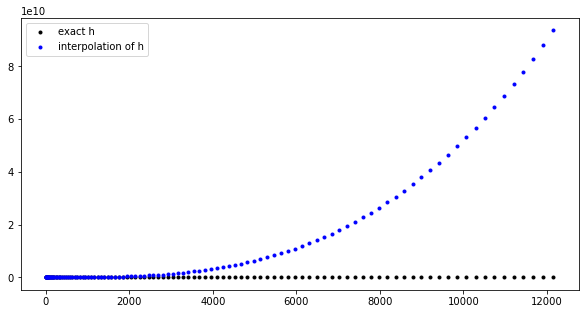

In [25]:
plt.figure(figsize=(10,5))
plt.plot(args[1,:], h_ginibre(args[1,:]), 'k.', label="exact h ")
plt.plot(args[1,:], approx_h_gin_interpolate(args[1,:]), 'b.', label="interpolation of h")
plt.legend()
plt.show()

In [26]:
args

array([[2.89159187e+02, 1.52356003e+03, 3.74433171e+03, ...,
        4.68587512e+06, 4.78162723e+06, 4.87832901e+06],
       [7.20377727e-01, 3.79562111e+00, 9.32819459e+00, ...,
        1.16738469e+04, 1.19123926e+04, 1.21533042e+04],
       [3.60638090e-01, 1.90017749e+00, 4.66991434e+00, ...,
        5.84420321e+03, 5.96362484e+03, 6.08423087e+03],
       ...,
       [7.24348110e-04, 3.81654078e-03, 9.37960722e-03, ...,
        1.17381876e+01, 1.19780481e+01, 1.22202875e+01],
       [7.23622312e-04, 3.81271660e-03, 9.37020883e-03, ...,
        1.17264259e+01, 1.19660461e+01, 1.22080427e+01],
       [7.22897968e-04, 3.80890008e-03, 9.36082927e-03, ...,
        1.17146878e+01, 1.19540681e+01, 1.21958225e+01]])

In [27]:
print(max(r_pcf), np.max(args))

31.67508015380314 4878329.006506744


# j'ai ajouter trop de valeur jusqu'au dernière point à evaluer pour sovir l'effet de r_max i.e. pour éliminer le problème d'interpolation  mais apparemnet le probleme est aussi dans la regularite de la fonction

In [28]:
# j'ai ajjouter trop de valeur pour soir l'effet de r_max mais apparemnet le probleme est dans la regularite de la fonction
N_ = 1000
h_ = 0.001
ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)
x_ = _get_x(h_, zeros_)
R_Max = np.floor(np.max(args))
ss = int(approx_pcf_gin["r"].shape[0]+ R_Max - np.floor(np.max(approx_pcf_gin["r"])))
big_r_interpolate = np.zeros((1,ss))
big_r_interpolate[0][: approx_pcf_gin["r"].shape[0]] = approx_pcf_gin["r"]
big_r_interpolate[0][approx_pcf_gin["r"].shape[0]:] = np.linspace(np.max(approx_pcf_gin["r"]) + 1, R_Max, int(R_Max - np.floor(np.max(approx_pcf_gin["r"]))))
big_pcf_gin = np.ones_like(big_r_interpolate)
big_pcf_gin[0][:approx_pcf_gin["pcf"].shape[0]] = approx_pcf_gin["pcf"]
big_h_gin =  big_pcf_gin -1
big_approx_h_gin_interpolate = interpolate.interp1d(big_r_interpolate.reshape(-1,), big_h_gin.reshape(-1,),  fill_value='extrapolate', kind='cubic')

big_approx_h_gin_interpolate(args[1,1:100])


array([ 1.42512452e-002,  5.26688430e-003,  1.06867750e-003,
       -1.81257177e-003,  2.55812453e-010, -5.36003655e-017,
       -2.14457595e-027, -9.44609690e-039,  5.84536951e-052,
       -3.45844926e-066, -1.29372963e-082, -1.81660194e-099,
       -5.53336353e-118,  4.62063629e-138,  1.93029064e-159,
        2.29129936e-182,  1.99529202e-206, -4.58000708e-232,
        2.75650471e-259,  1.39432751e-287,  1.37186319e-317,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,

In [29]:
big_pcf_gin[0]

array([0.        , 0.0061739 , 0.01653307, ..., 1.        , 1.        ,
       1.        ])

In [30]:
h_ginibre(args[1,1:100])

array([-5.53646421e-007, -1.62096092e-038, -5.37128033e-131,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000,

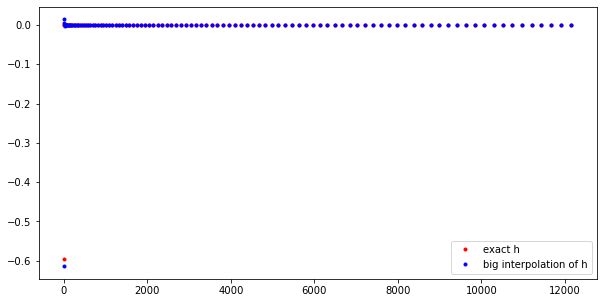

In [31]:
plt.figure(figsize=(10,5))
plt.plot(args[1,:], h_ginibre(args[1,:]), 'r.', label="exact h ")
plt.plot(args[1,:], big_approx_h_gin_interpolate(args[1,:]), 'b.', label="big interpolation of h")
plt.legend()
plt.show()

# Apparemment c'est régle sur les grande valeur on a zeros mais pour l'approximation elle prend trop de temps pour s'nnuler elle wigle trop

In [32]:

N_ = 1000
h_ = 0.1
wave_lengh_2 = np.linspace(0.1, 10, 500)
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(N_)]) / np.pi
x_ = _get_x(h_, zeros_)
args = np.divide.outer(x_, wave_lengh).T

ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)

R_Max = np.floor(np.max(args))
ss = int(approx_pcf_gin["r"].shape[0]+ R_Max - np.floor(np.max(approx_pcf_gin["r"])))
big_r_interpolate = np.zeros((1,ss))
big_r_interpolate[0][: approx_pcf_gin["r"].shape[0]] = approx_pcf_gin["r"]
big_r_interpolate[0][approx_pcf_gin["r"].shape[0]:] = np.linspace(np.max(approx_pcf_gin["r"]) + 1, R_Max, int(R_Max - np.floor(np.max(approx_pcf_gin["r"]))))
big_pcf_gin = np.ones_like(big_r_interpolate)
big_pcf_gin[0][:approx_pcf_gin["pcf"].shape[0]] = approx_pcf_gin["pcf"]
big_h_gin =  big_pcf_gin -1

big_approx_h_gin_interpolate = interpolate.interp1d(big_r_interpolate.reshape(-1,), big_h_gin.reshape(-1,),  fill_value='extrapolate', kind='cubic')

big_approx_gin_sf_1 = 1 + 1/np.pi*ft.transform(big_approx_h_gin_interpolate, wave_lengh_2, ret_err=False)
big_approx_gin_sf_2 = 1 + 1/np.pi*ft_2.transform(big_approx_h_gin_interpolate, wave_lengh_2)

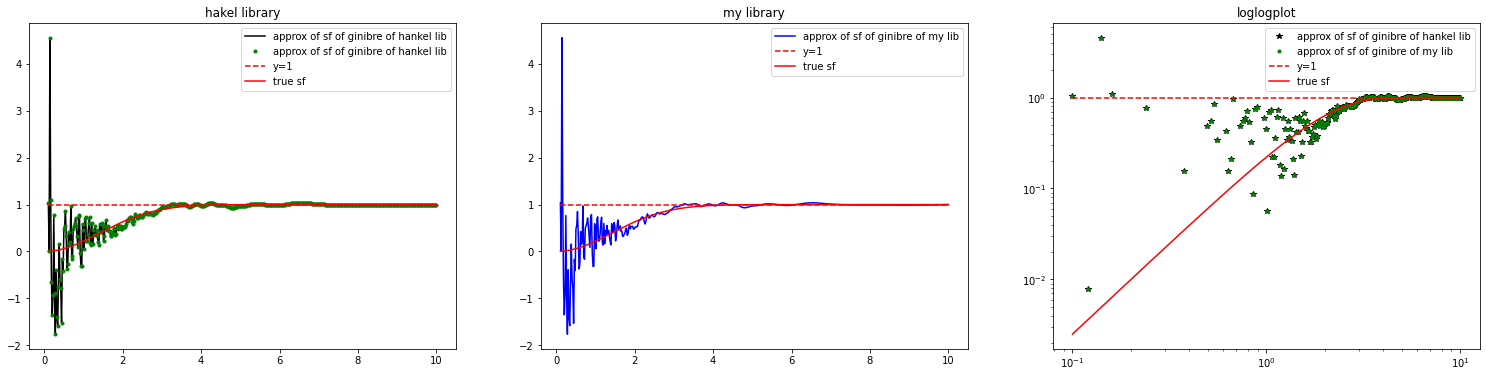

In [33]:
fig, ax = plt.subplots(1,3, figsize=(26,6))
ax[0].plot(wave_lengh_2, big_approx_gin_sf_1, 'k', label="approx of sf of ginibre of hankel lib")
ax[0].plot(wave_lengh_2, big_approx_gin_sf_1, 'g.', label="approx of sf of ginibre of hankel lib")
ax[0].plot(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
ax[0].plot(wave_lengh_2, true_sf_ginibre(wave_lengh_2), 'r', label="true sf")
ax[0].legend()
ax[0].title.set_text("hakel library")
ax[1].plot(wave_lengh_2, big_approx_gin_sf_2, 'b', label="approx of sf of ginibre of my lib")
ax[1].plot(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
ax[1].plot(wave_lengh_2, true_sf_ginibre(wave_lengh_2), 'r', label="true sf")
ax[1].legend()
ax[1].title.set_text("my library")
ax[2].loglog(wave_lengh_2, big_approx_gin_sf_1, 'k*', label="approx of sf of ginibre of hankel lib")
ax[2].loglog(wave_lengh_2, big_approx_gin_sf_2, 'g.', label="approx of sf of ginibre of my lib")
ax[2].loglog(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
ax[2].loglog(wave_lengh_2, true_sf_ginibre(wave_lengh_2), 'r', label="true sf")
ax[2].legend()
ax[2].title.set_text('loglogplot')
plt.show()

# pas de divergence mais c'est pas le bon resultat 
je pense que je veux alller voir la dexieme librairie pyhank pour comprendre pourquoi pour eux c'est mieux 

# Quasi hankel transform Vega and Sicairos 2004

In [34]:
from pyhank import HankelTransform
t = HankelTransform(order=0, radial_grid =approx_pcf_gin["r"] )

In [35]:
point_h_gin = np.array(approx_pcf_gin["pcf"]) - 1
exact_h_point = h_ginibre(approx_pcf_gin["r"])
intensity = 1/np.pi
sf_estimation = 1 + intensity*t.qdht(point_h_gin)
sf_estimation_3 = 1 + intensity*t.qdht(exact_h_point)
wv = t.kr

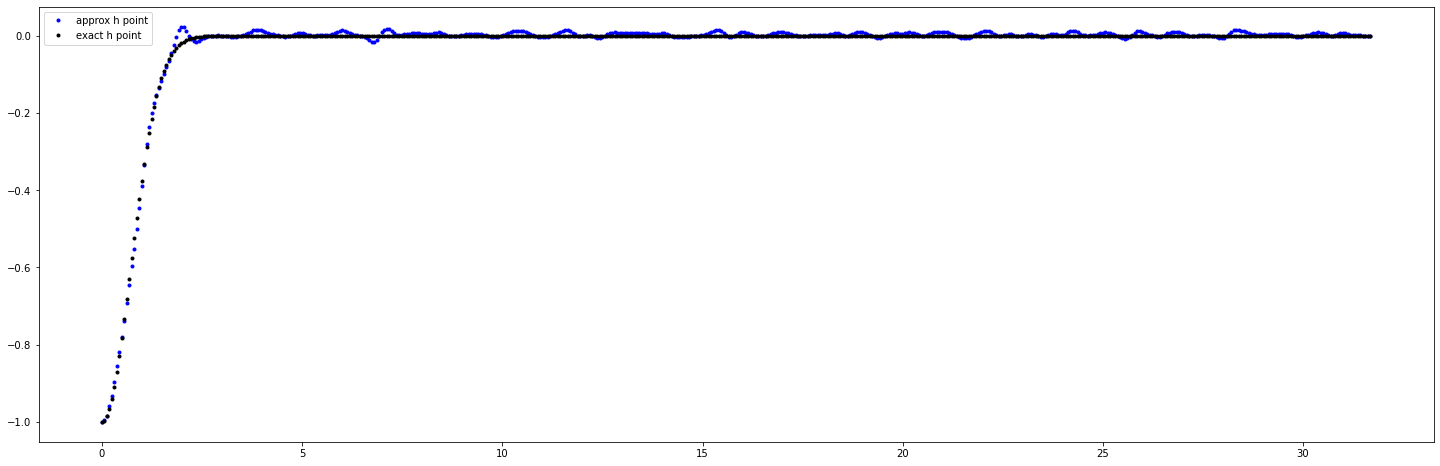

In [36]:
plt.figure(figsize=(25,8))
plt.plot(approx_pcf_gin["r"], point_h_gin, 'b.', label ="approx h point" )
plt.plot(approx_pcf_gin["r"], exact_h_point, 'k.', label ="exact h point" )
plt.legend()
plt.show()

In [37]:
point_h_gin[31]

0.013918951879416053

# pour voir si les wigle à la place de zero à la queue est ce qui cause un problème j'ai enlevé les wigle et les remplacé par zero et recalculer pour pyhank 

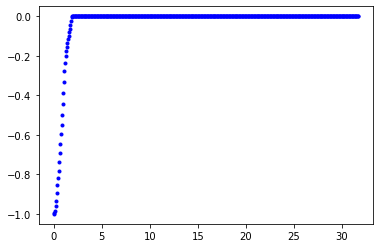

In [38]:
h_essay = point_h_gin
h_essay[31:] = 0
plt.plot(approx_pcf_gin["r"], h_essay, 'b.')
plt.show()

# for pyhank

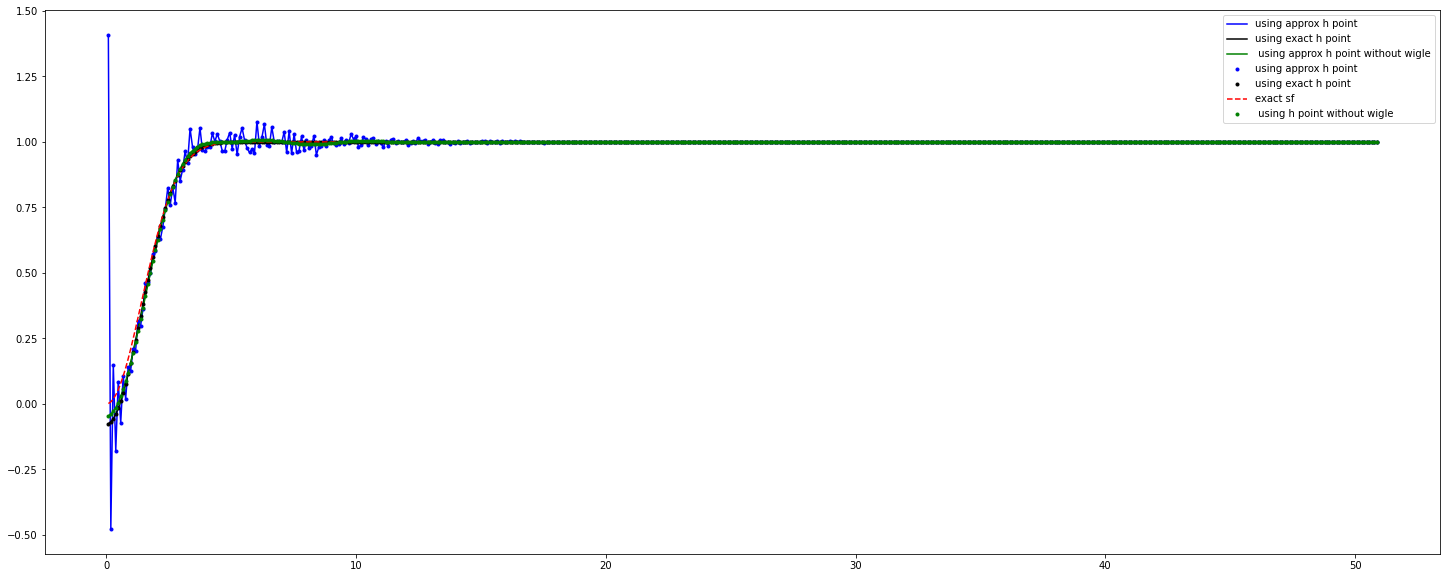

In [39]:
sf_essay = 1 + intensity*t.qdht(h_essay)
plt.figure(figsize=(25,10))
plt.plot(wv, sf_estimation, 'b', label ="using approx h point" )
plt.plot(wv, sf_estimation_3, 'k', label ="using exact h point" )
plt.plot(wv, sf_essay, 'g', label =" using approx h point without wigle" )
plt.plot(wv, sf_estimation, 'b.', label ="using approx h point" )
plt.plot(wv, sf_estimation_3, 'k.', label ="using exact h point" )
plt.plot(wv, true_sf_ginibre(wv), 'r--', label= "exact sf")
plt.plot(wv, sf_essay, 'g.', label =" using h point without wigle" )
plt.legend()
plt.show()

# oui il etais un problème apparement!

# for hankel

In [40]:
point_h_gin[:100]

array([-1.        , -0.9938261 , -0.98346693, -0.9589505 , -0.93345778,
       -0.89572829, -0.85508401, -0.81809729, -0.78046459, -0.73731435,
       -0.69196508, -0.6465014 , -0.59712036, -0.55121415, -0.50040923,
       -0.44644511, -0.3894839 , -0.33477899, -0.27932848, -0.23534116,
       -0.20126454, -0.17421212, -0.15413592, -0.13594825, -0.11652949,
       -0.0989277 , -0.0816376 , -0.06453421, -0.04398546, -0.02364031,
       -0.00289657,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [41]:
h_essay[:100]

array([-1.        , -0.9938261 , -0.98346693, -0.9589505 , -0.93345778,
       -0.89572829, -0.85508401, -0.81809729, -0.78046459, -0.73731435,
       -0.69196508, -0.6465014 , -0.59712036, -0.55121415, -0.50040923,
       -0.44644511, -0.3894839 , -0.33477899, -0.27932848, -0.23534116,
       -0.20126454, -0.17421212, -0.15413592, -0.13594825, -0.11652949,
       -0.0989277 , -0.0816376 , -0.06453421, -0.04398546, -0.02364031,
       -0.00289657,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [42]:

N_ = 2000
h_ = 0.00001
wave_lengh_2 = np.linspace(0.1, 10, 1000)
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(N_)]) / np.pi
x_ = _get_x(h_, zeros_)
args = np.divide.outer(x_, wave_lengh).T

ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)

point_h_gin = np.array(approx_pcf_gin["pcf"]) - 1
h_essay = point_h_gin
h_essay[50:] = 0

R_Max = np.floor(np.max(args))
ss = int(approx_pcf_gin["r"].shape[0]+ R_Max - np.floor(np.max(approx_pcf_gin["r"])))
big_r_interpolate = np.zeros((1,ss))
big_r_interpolate[0][: approx_pcf_gin["r"].shape[0]] = approx_pcf_gin["r"]
big_r_interpolate[0][approx_pcf_gin["r"].shape[0]:] = np.linspace(np.max(approx_pcf_gin["r"]) + 1, R_Max, int(R_Max - np.floor(np.max(approx_pcf_gin["r"]))))
big_h_essay = np.zeros_like(big_r_interpolate)
big_h_essay[0][:h_essay.shape[0]] = h_essay
big_approx_h_gin_interpolate = interpolate.interp1d(big_r_interpolate.reshape(-1,), big_h_essay.reshape(-1,),  fill_value='extrapolate', kind='cubic')
big_r_point = big_r_interpolate.reshape(-1,)

big_approx_gin_sf_1 = 1 + 1/np.pi*ft.transform(big_approx_h_gin_interpolate, wave_lengh_2, ret_err=False)
big_approx_gin_sf_2 = 1 + 1/np.pi*ft_2.transform(big_approx_h_gin_interpolate, wave_lengh_2)

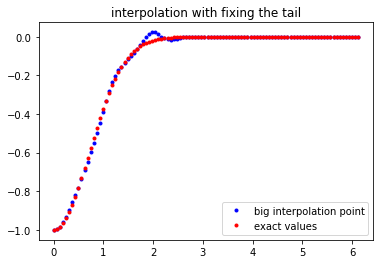

In [43]:
plt.plot(big_r_point[:100], big_approx_h_gin_interpolate(big_r_point[:100]), 'b.', label = "big interpolation point")
plt.plot(big_r_point[:100], h_ginibre(big_r_point[:100]), 'r.', label= "exact values")
plt.legend()
plt.title("interpolation with fixing the tail")
plt.show()

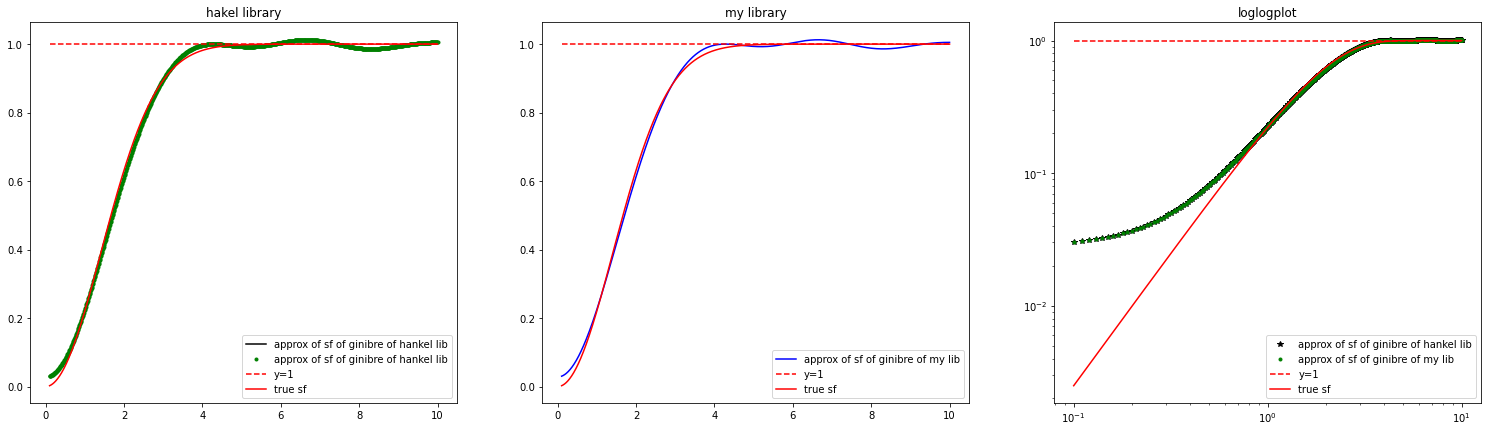

In [44]:
fig, ax = plt.subplots(1,3, figsize=(26,7))
ax[0].plot(wave_lengh_2, big_approx_gin_sf_1, 'k', label="approx of sf of ginibre of hankel lib")
ax[0].plot(wave_lengh_2, big_approx_gin_sf_1, 'g.', label="approx of sf of ginibre of hankel lib")
ax[0].plot(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
ax[0].plot(wave_lengh_2, true_sf_ginibre(wave_lengh_2), 'r', label="true sf")
ax[0].legend()
ax[0].title.set_text("hakel library")
ax[1].plot(wave_lengh_2, big_approx_gin_sf_2, 'b', label="approx of sf of ginibre of my lib")
ax[1].plot(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
ax[1].plot(wave_lengh_2, true_sf_ginibre(wave_lengh_2), 'r', label="true sf")
ax[1].legend()
ax[1].title.set_text("my library")
ax[2].loglog(wave_lengh_2, big_approx_gin_sf_1, 'k*', label="approx of sf of ginibre of hankel lib")
ax[2].loglog(wave_lengh_2, big_approx_gin_sf_2, 'g.', label="approx of sf of ginibre of my lib")
ax[2].loglog(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
ax[2].loglog(wave_lengh_2, true_sf_ginibre(wave_lengh_2), 'r', label="true sf")
ax[2].legend()
ax[2].title.set_text('loglogplot')
plt.show()

# it looks better let's try for equi

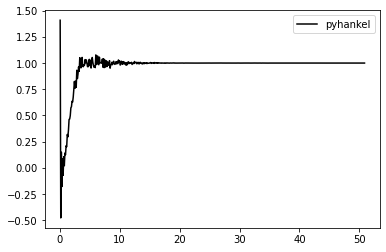

In [45]:
plt.plot(wv, sf_estimation, 'k', label ="pyhankel" )
#plt.plot(wave_lengh_2, big_approx_gin_sf_2, 'r', label = "hankel")
plt.legend()

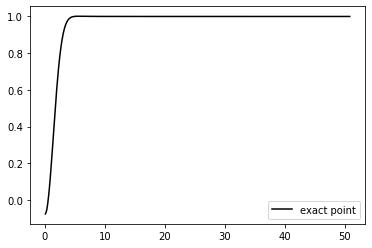

In [46]:
plt.plot(wv, sf_estimation_3, 'k', label ="exact point" )
#plt.plot(wave_lengh_2, big_approx_gin_sf_2, 'r', label = "hankel")
plt.legend()

# Why for points from the exact function i have smooth function and better at zero 

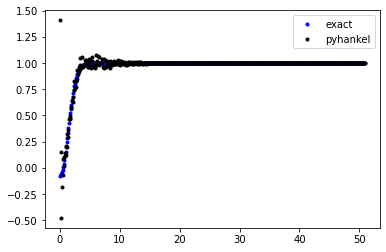

In [47]:
plt.plot(wv, sf_estimation_3, 'b.', label ="exact" )
plt.plot(wv, sf_estimation, 'k.', label ="pyhankel" )

plt.legend()

In [48]:
sf_estimation_3[:20]

array([-0.07550864, -0.06868252, -0.0565096 , -0.03916912, -0.0169176 ,
        0.00991957,  0.04095625,  0.07575478,  0.11383615,  0.15469094,
        0.19779049,  0.24259813,  0.28858007,  0.33521562,  0.38200653,
        0.42848528,  0.47422194,  0.51882981,  0.56196946,  0.60335141])

In [49]:
sf_estimation[:20]

array([ 1.40860914, -0.477979  ,  0.14964569, -0.17825372,  0.08536679,
       -0.07177757,  0.10600516,  0.01976516,  0.1408714 ,  0.12523714,
        0.21141445,  0.20179763,  0.31832558,  0.29552481,  0.36292293,
        0.4625548 ,  0.46523465,  0.49802112,  0.57240379,  0.58348823])

# what if i give a big R max does i get more points of k near zero???

In [50]:
R_Max_ = 100
ss = int(approx_pcf_gin["r"].shape[0]+ R_Max_ - np.floor(np.max(approx_pcf_gin["r"]))) # new size of r
big_r = np.zeros((1,ss))
big_r[0][: approx_pcf_gin["r"].shape[0]] = approx_pcf_gin["r"]
big_r[0][approx_pcf_gin["r"].shape[0]:] = np.linspace(np.max(approx_pcf_gin["r"]) + 1, R_Max_, int(R_Max_ - np.floor(np.max(approx_pcf_gin["r"]))))
big_pcf_gin_ = np.ones_like(big_r)
big_pcf_gin_[0][:approx_pcf_gin["pcf"].shape[0]] = approx_pcf_gin["pcf"]
big_h_gin_ =  big_pcf_gin_ -1


In [51]:
big_h_gin_.shape

(1, 582)

In [52]:
intensity = 1/np.pi

t_2 = HankelTransform(order=0, n_points =  big_r.shape[-1], max_radius= 100)
sf_estimation_2 = 1 + intensity*t_2.qdht(big_h_gin_.reshape(-1,))
wv_2 = t_2.kr

# that's good we have more points near zero

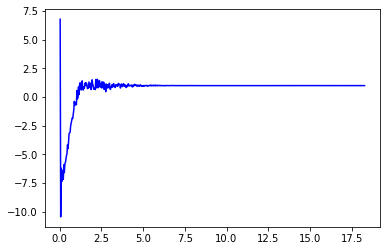

In [53]:
plt.plot(wv_2, sf_estimation_2, 'b')
plt.show()

In [54]:
#sf_estimation_2

# oh shit 

In [55]:
sf_estimation_2

array([ 6.78478779e+00, -1.04465720e+01, -6.20061973e+00, -7.36110828e+00,
       -7.18337240e+00, -6.37933311e+00, -7.16499241e+00, -5.89957055e+00,
       -6.58557237e+00, -5.79638519e+00, -5.71911697e+00, -5.40363444e+00,
       -5.10399728e+00, -4.94941810e+00, -4.16899845e+00, -4.49677385e+00,
       -3.91578389e+00, -3.19272390e+00, -3.13167393e+00, -3.06024784e+00,
       -2.51072373e+00, -2.28691639e+00, -2.09755966e+00, -1.81755138e+00,
       -1.86948823e+00, -1.52556652e+00, -1.11158300e+00, -3.76839635e-01,
       -7.25054213e-01, -6.14663385e-01, -4.57794880e-01, -6.64223483e-01,
        5.78946653e-01, -1.54489186e-01, -8.27329907e-03,  8.77756757e-01,
        2.14053577e-01,  1.07260620e+00,  1.24813490e+00,  7.46824780e-01,
        6.16395908e-01,  8.14605949e-01,  1.41364470e+00,  8.97275556e-01,
        6.15017323e-01,  9.06111661e-01,  7.71573633e-01,  1.01901672e+00,
        1.24299427e+00,  1.00440133e+00,  1.23274785e+00,  1.09830125e+00,
        7.38821710e-01,  

# let's try for equi since pcf is more smooth

/opt/anaconda3/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



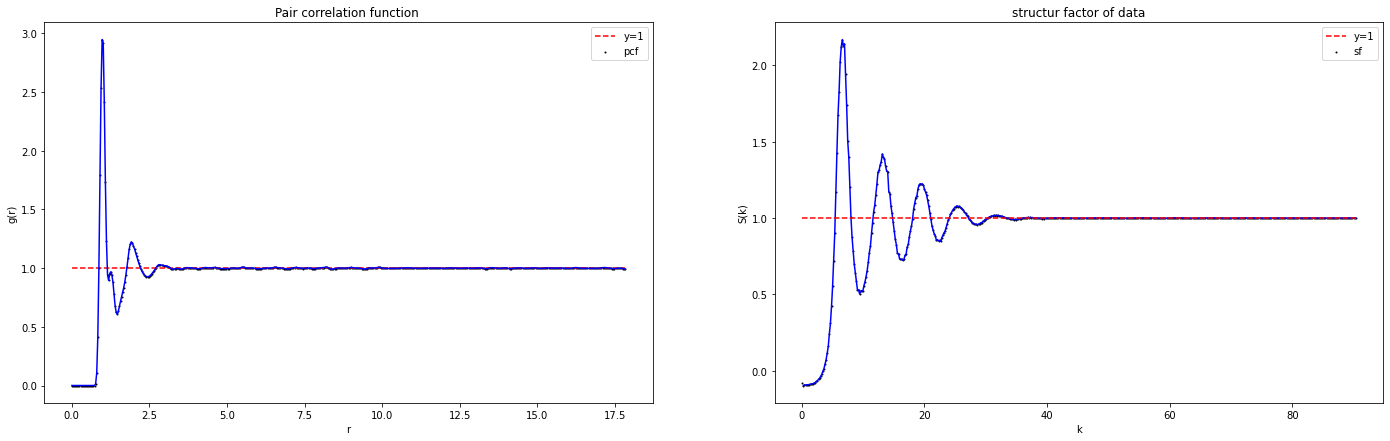

In [56]:
data_equi = StructureFactor(my_data_equi)
approx_pcf_equi = data_equi.get_pcf_estimate(100, 'fv', 'd')
k_equi, approx_sf_equi = data_equi.get_fourier_estimate('pcf','estimation_1', 1)

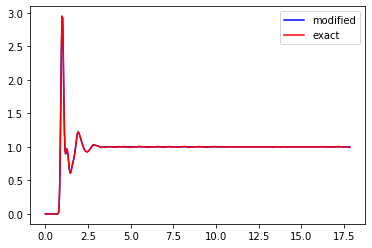

In [57]:
equi_point_mod = np.copy(approx_pcf_equi["pcf"])
equi_point_mod[100:] =1
r_point_equi = np.copy(approx_pcf_equi["r"])

plt.plot(r_point_equi, equi_point_mod, 'b', label="modified")
plt.plot(r_point_equi, approx_pcf_equi["pcf"], 'r', label = "exact")
plt.legend()
plt.show()

In [59]:

N_ = 2000
h_ = 0.00001
wave_lengh_2 = np.linspace(0.01, 50, 1000)
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(N_)]) / np.pi
x_ = _get_x(h_, zeros_)
args = np.divide.outer(x_, wave_lengh).T

ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)
 

R_Max = np.floor(np.max(args))
ss = int(approx_pcf_equi["r"].shape[0]+ R_Max - np.floor(np.max(approx_pcf_equi["r"])))# new size
big_r_interpolate_equi = np.zeros((1,ss))
big_r_interpolate_equi[0][: approx_pcf_equi["r"].shape[0]] = np.copy(approx_pcf_equi["r"])
big_r_interpolate_equi[0][approx_pcf_equi["r"].shape[0]:] = np.linspace(np.max(approx_pcf_equi["r"]) + 1, R_Max, int(R_Max - np.floor(np.max(approx_pcf_equi["r"]))))
big_pcf_equi = np.ones_like(big_r_interpolate_equi)
big_pcf_equi[0][:approx_pcf_equi["pcf"].shape[0]] = equi_point_mod
big_h_equi =  big_pcf_equi -1
big_r_point_equi = big_r_interpolate_equi.reshape(-1,)

big_approx_h_equi_interpolate = interpolate.interp1d(big_r_interpolate_equi.reshape(-1,), big_h_equi.reshape(-1,),  fill_value='extrapolate', kind='cubic')

big_approx_h_equi_interpolate(args[1,1:])


array([-1., -1., -1., ...,  0.,  0.,  0.])

In [61]:
big_approx_equi_sf_2 = 1 + ft.transform(big_approx_h_equi_interpolate, wave_lengh_2, ret_err=False)

In [62]:
h_mod_equi = equi_point_mod -1
intensity = 1

t_2 = HankelTransform(order=0, radial_grid= approx_pcf_equi["r"])
sf_estimation_equi_2 = 1 + intensity*t_2.qdht(h_mod_equi)
wv_2 = t_2.kr

In [63]:
np.max(approx_pcf_equi["r"])

17.836502430487712

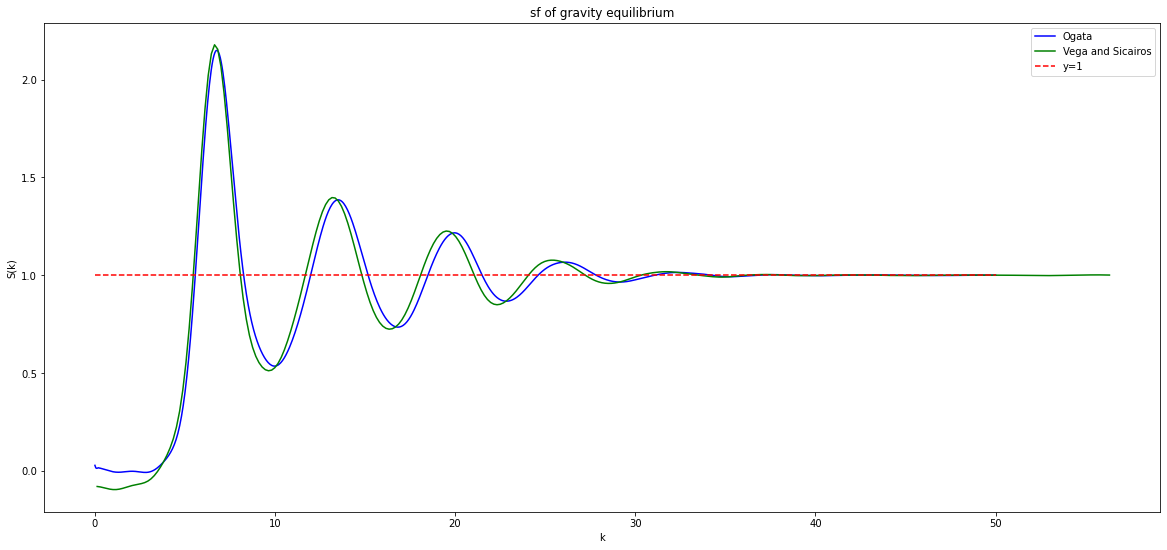

In [64]:
plt.figure(figsize=(20, 9))
plt.plot(wave_lengh_2, big_approx_equi_sf_2, 'b', label="Ogata")
plt.plot(wv_2[:320], sf_estimation_equi_2[:320], 'g', label="Vega and Sicairos")
plt.plot(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r--', label="y=1")
plt.title("sf of gravity equilibrium")
plt.xlabel("k")
plt.ylabel("S(k)")
plt.legend()
plt.show()

# j'essay d'augmenter h pour compenser les k petit near zeros

In [65]:

N_ = 100
h_ = 0.5
wave_lengh_2 = np.linspace(0, 0.05, 40)
zeros_= np.array([mpm.besseljzero(0, i + 1) for i in range(N_)]) / np.pi
x_ = _get_x(h_, zeros_)
args = np.divide.outer(x_, wave_lengh).T

ft = SymmetricFourierTransform(ndim=2, N=N_, h=h_)
ft_2 = Symmetric_Fourier_Transform_(N=N_, h=h_, ndim=2)
 

R_Max = np.floor(np.max(args))
ss = int(approx_pcf_equi["r"].shape[0]+ R_Max - np.floor(np.max(approx_pcf_equi["r"])))# new size
big_r_interpolate_equi = np.zeros((1,ss))
big_r_interpolate_equi[0][: approx_pcf_equi["r"].shape[0]] = approx_pcf_equi["r"]
big_r_interpolate_equi[0][approx_pcf_equi["r"].shape[0]:] = np.linspace(np.max(approx_pcf_equi["r"]) + 1, R_Max, int(R_Max - np.floor(np.max(approx_pcf_equi["r"]))))
big_pcf_equi = np.ones_like(big_r_interpolate_equi)
big_pcf_equi[0][:approx_pcf_equi["pcf"].shape[0]] = equi_point_mod
big_h_equi =  big_pcf_equi -1
big_r_point_equi = big_r_interpolate_equi.reshape(-1,)

big_approx_h_equi_interpolate = interpolate.interp1d(big_r_interpolate_equi.reshape(-1,), big_h_equi.reshape(-1,),  fill_value='extrapolate', kind='cubic')

#big_approx_h_equi_interpolate(args[1,1:])



In [66]:
big_approx_equi_sf_3 = 1 + ft.transform(big_approx_h_equi_interpolate, wave_lengh_2, ret_err=False)
#big_approx_equi_sf_3 = 1 + ft_2.transform(big_approx_h_equi_interpolate, wave_lengh_2)

/opt/anaconda3/lib/python3.8/site-packages/hankel/hankel.py:192: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_res = quad(integrand, 0, np.inf)


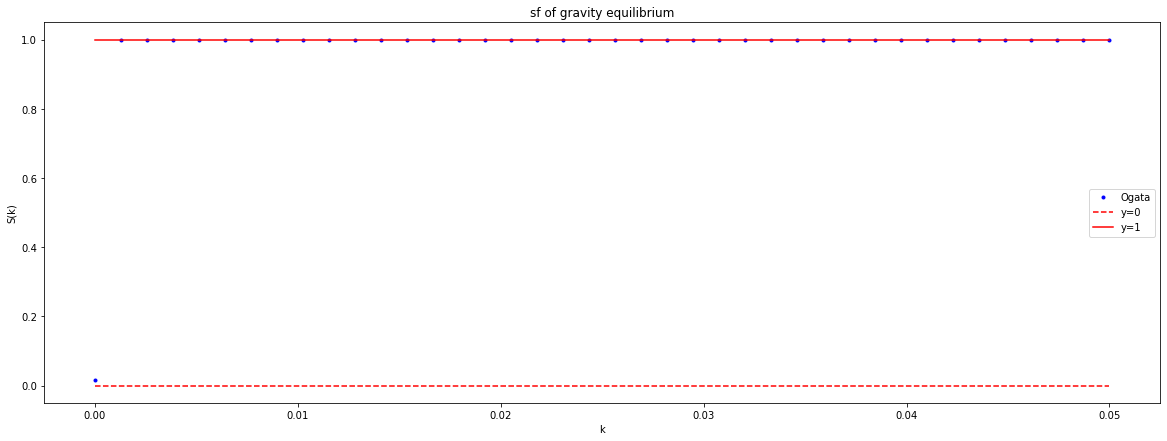

In [67]:
plt.figure(figsize=(20, 7))
plt.plot(wave_lengh_2, big_approx_equi_sf_3, 'b.', label="Ogata")
#plt.loglog(wv_2[:320], sf_estimation_equi_2[:320], 'k', label="Vega and Sicairos")
plt.plot(wave_lengh_2, np.zeros((wave_lengh_2.shape)), 'r--', label="y=0")
plt.plot(wave_lengh_2, np.ones((wave_lengh_2.shape)), 'r-', label="y=1")
plt.title("sf of gravity equilibrium")
plt.xlabel("k")
plt.ylabel("S(k)")
plt.legend()
plt.show()

# 


In [68]:
R_Max_ = 100
ss = int(approx_pcf_equi["r"].shape[0]+ 100*R_Max_ - np.floor(np.max(approx_pcf_equi["r"]))) # new size of r
big_r = np.zeros((1,ss))
big_r[0][: approx_pcf_equi["r"].shape[0]] = approx_pcf_equi["r"]
big_r[0][approx_pcf_equi["r"].shape[0]:] = np.linspace(np.max(approx_pcf_equi["r"]) + 1, 100*R_Max_, int(100*R_Max_ - np.floor(np.max(approx_pcf_equi["r"]))))
big_pcf_equi_ = np.ones_like(big_r)
big_pcf_equi_[0][:approx_pcf_gin["pcf"].shape[0]] = approx_pcf_equi["pcf"]
big_h_equi_ =  big_pcf_equi_ -1



In [69]:
big_h_equi_.shape

(1, 10496)

In [70]:
intensity = 1
t_2 = HankelTransform(order=0, n_points =  big_h_equi_.shape[-1], max_radius= 100000)
sf_estimation_equi_2 = 1 + intensity*t_2.qdht(big_h_equi_.reshape(-1,))
wv_2 = t_2.kr

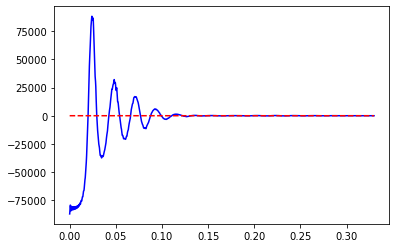

In [71]:
plt.plot(wv_2, sf_estimation_equi_2, 'b')
plt.plot(wv_2, np.ones((wv_2.shape)), 'r--', label="y=1")
plt.show()

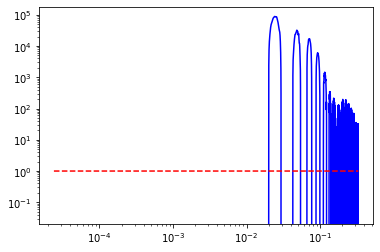

In [134]:
plt.loglog(wv_2, sf_estimation_equi_2, 'b')
plt.loglog(wv_2, np.ones((wv_2.shape)), 'r--', label="y=1")
plt.show()

In [135]:
wv_2[:50]

array([2.40482556e-05, 5.52007811e-05, 8.65372791e-05, 1.17915344e-04,
       1.49309177e-04, 1.80710640e-04, 2.12116366e-04, 2.43524715e-04,
       2.74934791e-04, 3.06346065e-04, 3.37758202e-04, 3.69170984e-04,
       4.00584258e-04, 4.31997917e-04, 4.63411884e-04, 4.94826099e-04,
       5.26240518e-04, 5.57655108e-04, 5.89069839e-04, 6.20484692e-04,
       6.51899648e-04, 6.83314693e-04, 7.14729816e-04, 7.46145006e-04,
       7.77560256e-04, 8.08975559e-04, 8.40390908e-04, 8.71806298e-04,
       9.03221726e-04, 9.34637188e-04, 9.66052680e-04, 9.97468199e-04,
       1.02888374e-03, 1.06029931e-03, 1.09171490e-03, 1.12313050e-03,
       1.15454613e-03, 1.18596177e-03, 1.21737742e-03, 1.24879309e-03,
       1.28020877e-03, 1.31162446e-03, 1.34304017e-03, 1.37445588e-03,
       1.40587160e-03, 1.43728734e-03, 1.46870308e-03, 1.50011882e-03,
       1.53153458e-03, 1.56295034e-03])